In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
seed = 4020

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
cityB_df = pd.read_csv("cityB_challengedata.csv")

In [4]:
cityB_df['d'].nunique()

75

In [5]:
cityB_df = cityB_df[cityB_df['uid']<=1000]

In [6]:
cityB_df

,uid,d,t,x,y
0,0,0,20,80,99
1,0,0,21,81,97
2,0,0,25,83,102
3,0,0,26,80,101
4,0,0,27,80,101
...,...,...,...,...,...
1110681,1000,74,21,178,56
1110682,1000,74,30,178,56
1110683,1000,74,32,178,56
1110684,1000,74,34,178,58


In [7]:
cityB_train = cityB_df[cityB_df['d']<=30]
cityB_val = cityB_df[
        (cityB_df['d']<=40) &
        (cityB_df['d']>=31)
]
cityB_test = cityB_df[
    (cityB_df['d']<=50) &
    (cityB_df['d']>=41)
    ]

In [8]:
sequences = (
        cityB_train.sort_values(by=['t'])  # Sort by 't' in ascending order
        .groupby(['uid', 'd'])  # Group by 'uid' and 'd'
        .apply(lambda group: list(zip(group['x'], group['y'])))  # Create list of (x, y) tuples
        .reset_index(name='coordinates')  # Reset index and give the aggregated column a name
)

sequences

,uid,d,coordinates
0,0,0,"[(80, 99), (81, 97), (83, 102), (80, 101), (80..."
1,0,1,"[(80, 101), (80, 100), (80, 101), (80, 101)]"
2,0,2,"[(82, 102), (90, 108), (90, 108), (90, 108), (..."
3,0,3,"[(90, 107), (91, 109), (90, 108), (90, 108), (..."
4,0,4,"[(82, 102), (90, 108), (91, 109), (92, 109), (..."
...,...,...,...
28275,1000,12,"[(178, 56), (178, 56), (197, 40), (169, 74), (..."
28276,1000,13,"[(186, 52), (190, 48), (190, 48), (197, 38)]"
28277,1000,15,"[(193, 44)]"
28278,1000,18,"[(199, 39), (181, 18), (187, 23), (193, 30)]"


In [9]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]


# Collate function to pad sequences in each batch
def collate_fn(batch):
    sequences, targets = zip(*batch)
    # Pad sequences to the max length in the batch
    padded_sequences = pad_sequence(sequences, batch_first=True) # pad before the start
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.int64)  # Get original lengths

    padded_targets = pad_sequence(targets, batch_first=True)  # (batch, max_seq_len, output_dim)
    return padded_sequences, padded_targets, lengths


In [10]:
def process_df(df, batch_size=32):

    """
    prepares each dataframe for training by loading it into a dataloader of the specified batchsize
    """

    df = df[df['uid']<=1000] # limit to first 1000 uid
    #df['coordinate_id'] = pd.factorize(list(zip(df['x'], df['y'])))[0] #encode into class labels

    sequences = (
        df.sort_values(by=['t'])  # Sort by 't' in ascending order
        .groupby(['uid', 'd'])  # Group by 'uid' and 'd'
        .apply(lambda group: list(zip(group['x'], group['y'])))  # Create list of (x, y) tuples
        .reset_index(name='coordinates')  # Reset index and give the aggregated column a name
)

    sequences['target'] = sequences['coordinates'].apply(lambda coords: coords[-1])  # Last  id
    sequences['coordinates'] = sequences['coordinates'].apply(lambda coords: coords[:-1])  # All except last

    sequences = sequences[(sequences['coordinates'].str.len() > 0)] # remove rows with no train data


    coordinates = sequences['coordinates'].apply(lambda seq: torch.tensor([(x, y) for x, y in seq], dtype=torch.float32))
    targets = sequences['target'].apply(lambda coord: torch.tensor(coord, dtype=torch.float32))

    dataset = SequenceDataset(coordinates.tolist(), torch.stack(targets.tolist()))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    return dataloader



In [11]:
train_loader = process_df(cityB_train)
val_loader = process_df(cityB_val)
test_loader = process_df(cityB_test)

____

___

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
class coordRNN(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
    super(coordRNN, self).__init__()
    self.num_layers = num_hidden
    self.hidden_size = hidden_d
    self.rnn = nn.RNN(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden, bidirectional=True)
    self.fc = nn.Linear(2 * hidden_d, out_d)

  def forward(self, x, lengths):
    h0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(device)
    # Pack the padded sequence
    x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
    r_packed, h = self.rnn(x_packed, h0)
    # Unpack the sequence
    last_timestep = torch.cat((h[-2], h[-1]), dim=-1)
    y = self.fc(last_timestep)
    return y

Epoch 1, Train Loss: 9156.8845
Epoch 1, Validation Loss: 8534.2758

Epoch 2, Train Loss: 7956.5192
Epoch 2, Validation Loss: 7410.7129

Epoch 3, Train Loss: 6899.1230
Epoch 3, Validation Loss: 6412.7943

Epoch 4, Train Loss: 5968.4382
Epoch 4, Validation Loss: 5545.0126

Epoch 5, Train Loss: 5151.8793
Epoch 5, Validation Loss: 4778.8110

Epoch 6, Train Loss: 4432.9574
Epoch 6, Validation Loss: 4103.2979

Epoch 7, Train Loss: 3802.3238
Epoch 7, Validation Loss: 3515.6794

Epoch 8, Train Loss: 3254.9434
Epoch 8, Validation Loss: 3007.0918

Epoch 9, Train Loss: 2786.5642
Epoch 9, Validation Loss: 2577.6359

Epoch 10, Train Loss: 2393.4184
Epoch 10, Validation Loss: 2219.7298

Epoch 11, Train Loss: 2069.7427
Epoch 11, Validation Loss: 1930.6376

Epoch 12, Train Loss: 1809.4893
Epoch 12, Validation Loss: 1698.2274

Epoch 13, Train Loss: 1604.1396
Epoch 13, Validation Loss: 1516.8015

Epoch 14, Train Loss: 1444.2420
Epoch 14, Validation Loss: 1377.1270

Epoch 15, Train Loss: 1320.5805
Epoch 

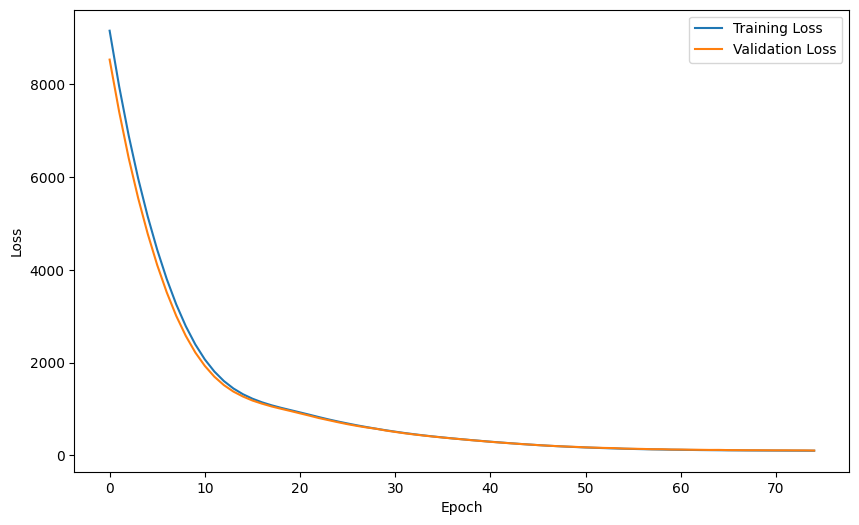

In [14]:
in_d = 2
out_d = in_d
hidden_d = 8
num_hidden = 1

rnn = coordRNN(in_d, out_d, hidden_d, num_hidden).to(device)

criterion = nn.MSELoss()
opt = optim.AdamW(rnn.parameters(), lr=0.0005)

train_loss_history = []  # To track training loss
val_loss_history = []    # To track validation loss
n_epochs = 75

# Training and evaluation loop
for e in range(n_epochs):
    rnn.train()
    cumulative_error = 0

    for x, y, lengths in train_loader:
        x, y, lengths = x.to(device), y.to(device), lengths.cpu()
        pred = rnn(x, lengths)

        err = criterion(pred, y)
        opt.zero_grad()
        err.backward()
        opt.step()

        cumulative_error += err.item()

    avg_train_loss = cumulative_error / len(train_loader)  # Average training loss for the epoch
    train_loss_history.append(avg_train_loss)
    print(f"Epoch {e+1}, Train Loss: {avg_train_loss:.4f}")

    rnn.eval()
    val_loss = 0.0
    results = {"actual": [], "predicted": []}

    with torch.no_grad():
        for x, y, lengths in val_loader:
            x, y, lengths = x.to(device), y.to(device), lengths.cpu()
            pred = rnn(x, lengths)

            results['actual'].append(y.cpu().numpy())
            results['predicted'].append(pred.cpu().numpy())

            loss = criterion(pred, y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)  # Average validation loss for the epoch
    val_loss_history.append(avg_val_loss)
    print(f"Epoch {e+1}, Validation Loss: {avg_val_loss:.4f}\n")

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


In [15]:
rnn.eval()
test_loss = 0.0
d = {
     "actual": [],
     "predicted": []
  }

with torch.no_grad():
  for x, y, lengths in test_loader:
    x, y, lengths = x.to(device), y.to(device), lengths.cpu()
    pred = rnn(x, lengths)

    d['actual'].append(y.cpu())
    d['predicted'].append(pred.cpu())

    loss = criterion(pred, y)
    test_loss += loss.item()

  avg_val_loss = test_loss / len(test_loader)
  print(f"Test Loss: {avg_val_loss:.4f}\n")



Test Loss: 97.3825



In [16]:
len(d['actual']), len(d['predicted'])

(282, 282)

In [18]:
actual = []
predicted = []
for i in range(len(d['actual'])):
    batched_actual = d['actual'][i]
    batched_pred = d['predicted'][i]
    actual.extend(list(np.array(batched_actual)))
    predicted.extend(list(np.array(batched_pred)))

df = pd.DataFrame(
    {
        "pred": predicted,
        "actual": actual
    }
)

df

,pred,actual
0,"[151.58977, 183.13867]","[168.0, 200.0]"
1,"[47.865963, 131.52829]","[46.0, 128.0]"
2,"[89.6364, 96.0621]","[91.0, 94.0]"
3,"[79.02945, 96.451485]","[77.0, 88.0]"
4,"[66.11116, 120.355095]","[48.0, 121.0]"
...,...,...
8989,"[21.936916, 184.15712]","[15.0, 199.0]"
8990,"[90.288086, 150.17303]","[90.0, 142.0]"
8991,"[179.52953, 36.45614]","[197.0, 36.0]"
8992,"[80.561935, 94.941826]","[80.0, 96.0]"


In [19]:
def calculate_l2_distance(row):
    pred_x, pred_y = row['pred']
    actual_x, actual_y = row['actual']
    return np.sqrt((pred_x - actual_x)**2 + (pred_y - actual_y)**2)

# Apply function to each row to create the 'L2_distance' column
df['L2_distance'] = df.apply(calculate_l2_distance, axis=1)

# Display the DataFrame
df

,pred,actual,L2_distance
0,"[151.58977, 183.13867]","[168.0, 200.0]",23.528708
1,"[47.865963, 131.52829]","[46.0, 128.0]",3.991321
2,"[89.6364, 96.0621]","[91.0, 94.0]",2.472181
3,"[79.02945, 96.451485]","[77.0, 88.0]",8.691735
4,"[66.11116, 120.355095]","[48.0, 121.0]",18.122639
...,...,...,...
8989,"[21.936916, 184.15712]","[15.0, 199.0]",16.383892
8990,"[90.288086, 150.17303]","[90.0, 142.0]",8.178110
8991,"[179.52953, 36.45614]","[197.0, 36.0]",17.476428
8992,"[80.561935, 94.941826]","[80.0, 96.0]",1.198125


Text(0, 0.5, 'Frequency')

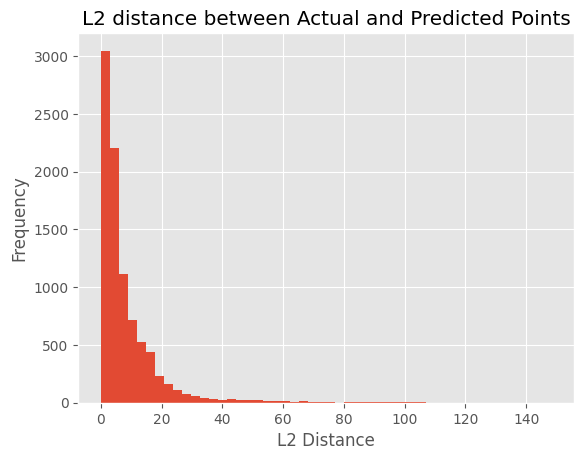

In [20]:
plt.style.use('ggplot')
plt.hist(df['L2_distance'], bins=50)
plt.title('L2 distance between Actual and Predicted Points')
plt.xlabel('L2 Distance')
plt.ylabel('Frequency')

In [21]:
print(f"RMSE: {np.sqrt((df['L2_distance'] ** 2).mean())}")

RMSE: 13.977695511683097


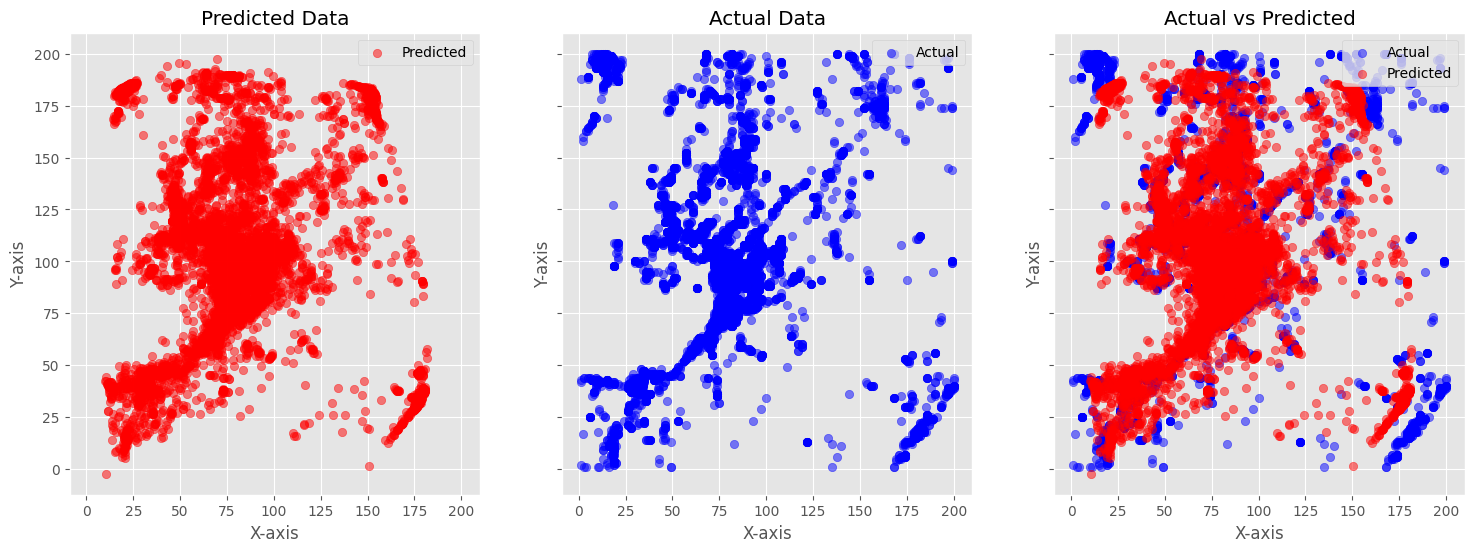

In [22]:
actual, predicted = np.array(actual), np.array(predicted)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

axes[0].scatter(predicted[:, 0], predicted[:, 1], label="Predicted", color="red", alpha=0.5)
axes[0].set_title("Predicted Data")
axes[0].set_xlabel("X-axis")
axes[0].set_ylabel("Y-axis")
axes[0].legend(loc='upper right')

axes[1].scatter(actual[:, 0], actual[:, 1], label="Actual", color="blue", alpha=0.5)
axes[1].set_title("Actual Data")
axes[1].set_xlabel("X-axis")
axes[1].set_ylabel("Y-axis")
axes[1].legend(loc='upper right')

axes[2].scatter(actual[:, 0], actual[:, 1], label="Actual", color="blue", alpha=0.5)
axes[2].scatter(predicted[:, 0], predicted[:, 1], label="Predicted", color="red", alpha=0.5)
axes[2].set_title("Actual vs Predicted")
axes[2].set_xlabel("X-axis")
axes[2].set_ylabel("Y-axis")
axes[2].legend(loc='upper right')

plt.show()